In [6]:
import numpy as np
import matplotlib.pyplot as plt
import cv2


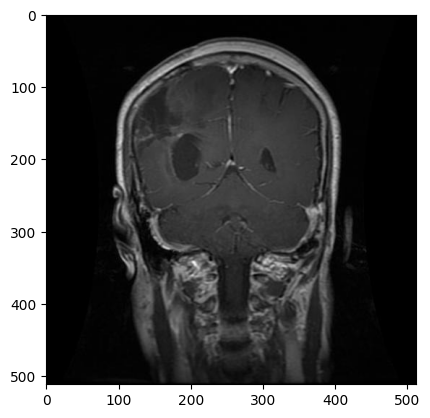

In [5]:
from PIL import Image
im = Image.open('data/Training/glioma/Tr-gl_0010.jpg')
plt.imshow(im)

In [14]:
im.getdata()[3333]

(1, 1, 1)